In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import seaborn as sns
import logging
# В utils мы реализуем дополнительные функции для визуализации процессора обучения
import utils
# Настраиваем логирование
logging.getLogger("tensorflow").setLevel(logging.ERROR)
# Настраиваем стиль графиков
sns.set_style('darkgrid')
# Проверяем подходит ли наша GPU для tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

In [2]:
# Рисует график обучения
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range (start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss  = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest  = vloss[index_loss]
    index_acc   = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'Лучшая эпоха= '+ str(index_loss + 1 + start_epoch)
    vc_label = 'Лучшая эпоха= '+ str(index_acc  + 1 + start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols = 2, figsize = (20,8))
    axes[0].plot (Epochs,tloss, 'r', label = 'Потери при обучении')
    axes[0].plot (Epochs,vloss,'g',label='Потери при валидации' )
    axes[0].scatter (index_loss + 1 + start_epoch,val_lowest, s = 150, c = 'blue', label = sc_label)
    axes[0].set_title('Потери при валидации и обучении')
    axes[0].set_xlabel('Эпохи')
    axes[0].set_ylabel('Потери')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r', label = 'Точность при обучении')
    axes[1].plot (Epochs,vacc,'g', label = 'Точность при валидации')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s = 150, c = 'blue', label = vc_label)
    axes[1].set_title  ('Точность при валидации и обучении')
    axes[1].set_xlabel ('Эпохи')
    axes[1].set_ylabel ('Точность')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()
# Создаем data_frame, в котором название папки является меткой класса изображений 
# Каждому элементу data_frame будет присвоена метка (DX) и название файла (image)
# Функция возвращает объект frame
def load_data_frame(sdir):
    classlist = os.listdir(sdir)
    filepaths = []
    labels = []
    for klass in classlist:
        classpath=os.path.join(sdir, klass)
        flist=os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append( fpath.replace('\\', '/') )
            labels.append(klass)

    Fseries=pd.Series( filepaths, name = 'image' )
    Lseries=pd.Series(labels, name = 'dx')
    return pd.concat([Fseries, Lseries], axis=1)

Подготавливаем обучающие данные для модели:

In [3]:
# Размер картинки для подачи в модели
height   = 64
width    = 64
channels = 3

# Размер пачки для обучения
batch_size = 20
# Размер пачки для валидации
test_batch_size = 50

# Инициализаци рандом: None - всегда рандом, Число - повторяемый рандом
my_random = None

# Загружаем сгенерированные картинки (картинка должны лежать по папкам с названием их DX)
df2 = load_data_frame ("./EuroSAT/")

# Разделяем выборку на обучающую, тестовую и валидационную (случайным образом)
train_df, test_df = train_test_split (df2, train_size= .9, shuffle = True, random_state = my_random)
valid_df, test_df = train_test_split (test_df, train_size= .5, shuffle = True, random_state = my_random)

# Задаем параметры входящей картинки
img_shape = (height, width, channels)
img_size  = (height, width)
length    = len(test_df)

# выводим найденное число n
test_steps = int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

# C помощью ImageDataGenerator () можно аугментировать изображения прямо во время обучения
trgen = ImageDataGenerator()

# Генератор для тестовой выборки
tvgen = ImageDataGenerator()

# Выборка для обучения модели
train_gen = trgen.flow_from_dataframe ( train_df, directory = None, x_col = "image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

# Выборка для тестирования сети после обучения
test_gen = tvgen.flow_from_dataframe ( test_df, directory = None, x_col= "image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# Выборка для тестирования сети во время обучения
valid_gen = tvgen.flow_from_dataframe ( valid_df, directory = None, x_col="image", y_col = "dx", target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle = True, batch_size = batch_size)

test batch size:  50   test steps:  27
Found 24300 validated image filenames belonging to 10 classes.
Found 1350 validated image filenames belonging to 10 classes.
Found 1350 validated image filenames belonging to 10 classes.


Создаём архитектуру модели:

In [4]:
# Получаем метки классов
classes     = list (train_gen.class_indices.keys())
class_count = len(classes)
train_steps = np.ceil(len(train_gen.labels)/batch_size)
# Задаем имя модели
model_name = 'EfficientNetB0'
# Генерируем экземпляр модели EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max')
# Создаем выходной слой
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis = -1, momentum = 0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(0.016), activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006), activation = 'relu')(x)
x = Dropout(rate = .45, seed = my_random)(x)
#Создаем выходной полносвязный слой и присоединяем его к предыдущим слоям (количество нейронов совпадает с количеством классов
output = Dense(class_count, activation = 'softmax')(x)
# Собираем модель вместе
model = Model(inputs = base_model.input, outputs = output)
# Компилируем модель 
model.compile(Adamax(learning_rate = .001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [5]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        keys = list(logs.keys())
        print("Starting training; got log keys: {}".format(keys))

    def on_train_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop training; got log keys: {}".format(keys))

    def on_epoch_begin(self, epoch, logs=None):
        keys = list(logs.keys())
        print("Start epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))

    def on_test_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start testing; got log keys: {}".format(keys))

    def on_test_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop testing; got log keys: {}".format(keys))

    def on_predict_begin(self, logs=None):
        keys = list(logs.keys())
        print("Start predicting; got log keys: {}".format(keys))

    def on_predict_end(self, logs=None):
        keys = list(logs.keys())
        print("Stop predicting; got log keys: {}".format(keys))

    def on_train_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: start of batch {}; got log keys: {}".format(batch, keys))

    def on_test_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Evaluating: end of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_begin(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: start of batch {}; got log keys: {}".format(batch, keys))

    def on_predict_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        print("...Predicting: end of batch {}; got log keys: {}".format(batch, keys))

Обучаем модель:

Starting training; got log keys: []
Start epoch 0 of training; got log keys: []
...Training: start of batch 0; got log keys: []
...Training: end of batch 0; got log keys: ['accuracy', 'loss']
...Training: start of batch 1; got log keys: []
...Training: end of batch 1; got log keys: ['accuracy', 'loss']
...Training: start of batch 2; got log keys: []
...Training: end of batch 2; got log keys: ['accuracy', 'loss']
...Training: start of batch 3; got log keys: []
...Training: end of batch 3; got log keys: ['accuracy', 'loss']
...Training: start of batch 4; got log keys: []
...Training: end of batch 4; got log keys: ['accuracy', 'loss']
...Training: start of batch 5; got log keys: []
...Training: end of batch 5; got log keys: ['accuracy', 'loss']
...Training: start of batch 6; got log keys: []
...Training: end of batch 6; got log keys: ['accuracy', 'loss']
...Training: start of batch 7; got log keys: []
...Training: end of batch 7; got log keys: ['accuracy', 'loss']
...Training: start of ba

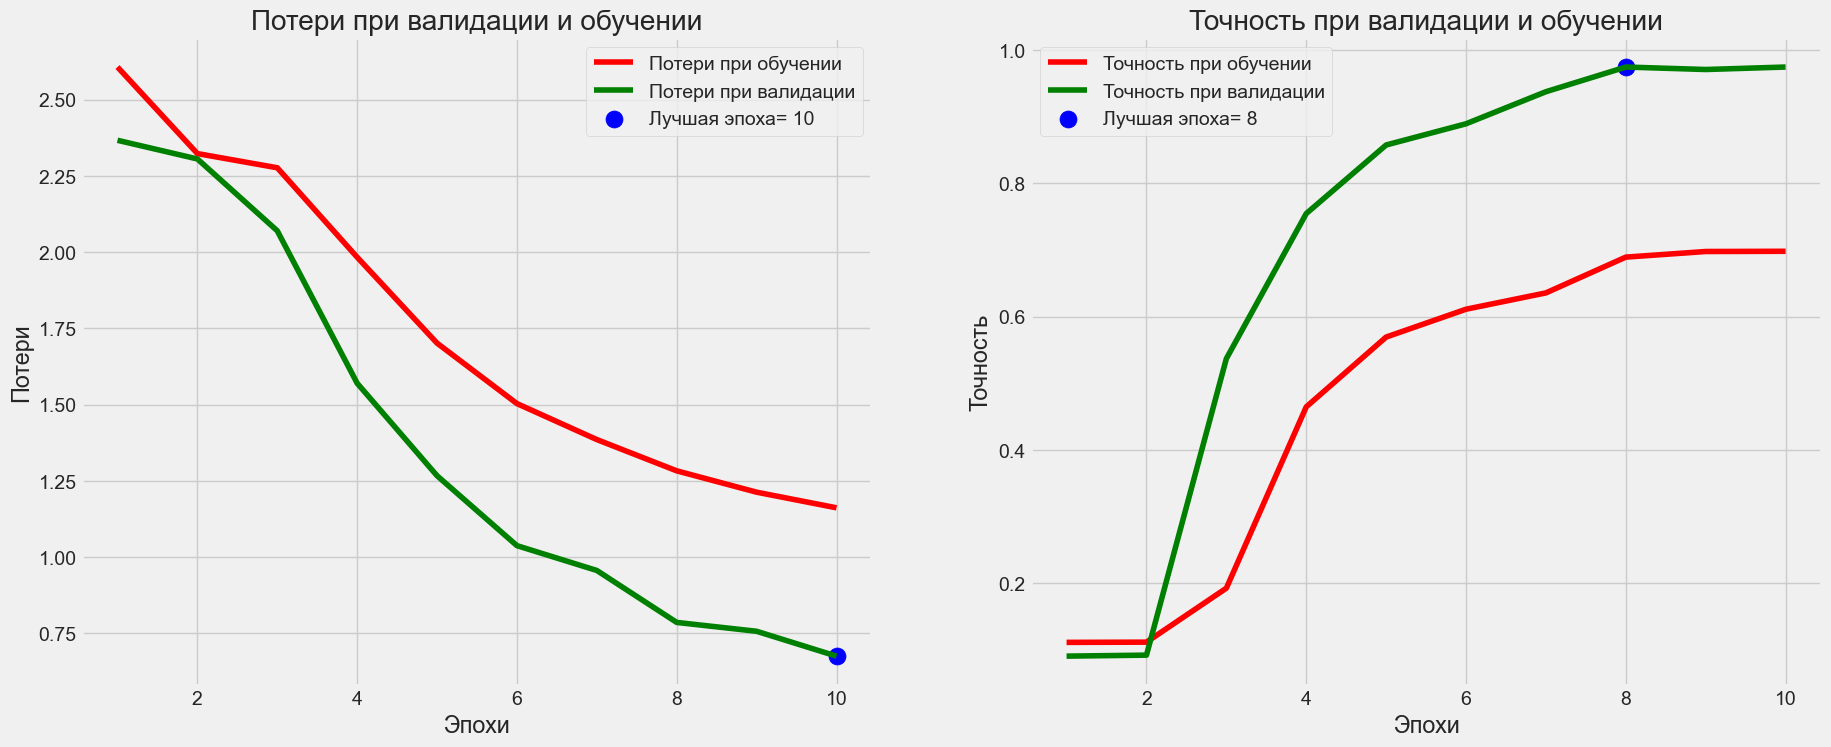

27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.9660 - loss: 1.0880
accuracy on the test set is 97.33 %



model was saved as ./EfficientNetB0-EuroSat_maps-97.33.h5

class csv file was saved as ./class_dict.csv



In [7]:
# Задаем параметры обучения
epochs        = 10 # Количество эпох
patience      = 1 # количество эпох, в течение которых необходимо отрегулировать lr, если отслеживаемое значение не улучшится
stop_patience = 6 # количество эпох ожидания перед остановкой обучения, если отслеживаемое значение не улучшится
threshold     = .9 
factor        = .5 
dwell         = True # если True и отслеживаемая метрика не улучшаются по сравнению с текущей эпохой, возвращают веса модели к весам предыдущей эпохи.
freeze        = False # 
ask_epoch     = 10 # количество эпох, которые нужно выполнить, прежде чем спросить, хотите ли вы остановить обучение
batches       = train_steps


# Запускаем обучение модели и сохраняем историю обучения
my_callback = CustomCallback()
history = model.fit (x = train_gen,  epochs = epochs, verbose = 0,callbacks = my_callback,
                       validation_data = valid_gen, validation_steps = None,  shuffle = False,  initial_epoch = 0)

# Рисуем график обучения и выводим
tr_plot(history,0)
# Проверяем точность модели на тестовой выборке и выводим результат тестирования
save_dir = './'
subject = 'EuroSat_maps'

acc = model.evaluate( test_gen, batch_size = test_batch_size, verbose = 1, steps=test_steps, return_dict = False)[1]*100
msg = f'accuracy on the test set is {acc:5.2f} %'
utils.print_in_color(msg, (0,255,0),(55,65,80))

# Сохраняем модель в файл, его потом можно загрузить и использовать без обучения для классификации изображений
save_id   = str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc  = os.path.join(save_dir, save_id)
model.save(save_loc)
generator = train_gen
scale     = 1
result    = utils.saver(save_dir, model, model_name, subject, acc, img_size, scale,  generator)